# Final Project for ITCS 3156
## Alec Pike
## Project Code



## Topic: 
Given a word, determine whether the word is English or Mandarin Chinese based on letter frequencies. 

### Python Imports

In [1]:
from typing import List, Dict, Tuple, Callable
import os
import gc
import traceback
import warnings
from pdb import set_trace

import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1 Data Preparation
## 1.1 Import CSV



In [2]:
words_df = pd.read_csv("EnglishMandarinWords.csv")

words_df.info()
print()
print("*" * 40)
print()
print(words_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41538 entries, 0 to 41537
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   word      41529 non-null  object
 1   language  41538 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 649.2+ KB

****************************************

                         word  language
0                         the         1
1                          of         1
2                         and         1
3                          to         1
4                           a         1
...                       ...       ...
41533                nu4 hou3         0
41534                zhi2 xi4         0
41535  kong1 zhong1 fei1 ren2         0
41536         xiang1 si1 shu4         0
41537            ding4 zheng4         0

[41538 rows x 2 columns]


## 1.2 Convert to letter frequencies

### 1.2.1 Frequency extraction function

In [3]:
def extract_letter_frequencies(string):

    alphabet = "abcdefghijklmnopqrstuvwxyz"
    out_arr = np.zeros((26,), dtype=int)
    lowercase_string = string.lower()

    for L in alphabet:
        for l in lowercase_string:
            if L == l:
                out_arr[alphabet.index(L)] += 1

    return out_arr

# Testing
test_string = "banana"
test_freqs = extract_letter_frequencies(test_string)
print(test_freqs)

[3 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]


### 1.2.2 Convert feature data to letter frequencies

In [4]:
freqs_arr = np.empty((len(words_df), 26), dtype=int)
words_arr = words_df['word'].values
print(words_arr)

for i in range(len(words_arr)):
    # skip non-string data
    # It seems there was an instance of the word "zero" in the database being parsed as the number 0 by accident
    if type(words_arr[i]) != str:
        continue
    freqs_arr[i] = extract_letter_frequencies(words_arr[i])

print(freqs_arr)

['the' 'of' 'and' ... 'kong1 zhong1 fei1 ren2' 'xiang1 si1 shu4'
 'ding4 zheng4']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [1 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 1]]


## 1.3 Visualization

### 1.3.1 Temporarily convert back to DataFrame

In [5]:
alphabet = "abcdefghijklmnopqrstuvwxyz"
freqs_df = pd.DataFrame(freqs_arr, columns=list(alphabet))
print(freqs_df)

       a  b  c  d  e  f  g  h  i  j  ...  q  r  s  t  u  v  w  x  y  z
0      0  0  0  0  1  0  0  1  0  0  ...  0  0  0  1  0  0  0  0  0  0
1      0  0  0  0  0  1  0  0  0  0  ...  0  0  0  0  0  0  0  0  0  0
2      1  0  0  1  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0  0
3      0  0  0  0  0  0  0  0  0  0  ...  0  0  0  1  0  0  0  0  0  0
4      1  0  0  0  0  0  0  0  0  0  ...  0  0  0  0  0  0  0  0  0  0
...   .. .. .. .. .. .. .. .. .. ..  ... .. .. .. .. .. .. .. .. .. ..
41533  0  0  0  0  0  0  0  1  0  0  ...  0  0  0  0  2  0  0  0  0  0
41534  0  0  0  0  0  0  0  1  2  0  ...  0  0  0  0  0  0  0  1  0  1
41535  0  0  0  0  2  1  2  1  1  0  ...  0  1  0  0  0  0  0  0  0  1
41536  1  0  0  0  0  0  1  1  2  0  ...  0  0  2  0  1  0  0  1  0  0
41537  0  0  0  1  1  0  2  1  1  0  ...  0  0  0  0  0  0  0  0  0  1

[41538 rows x 26 columns]


### 1.3.2 Plot data with Seaborn

<Figure size 640x480 with 0 Axes>

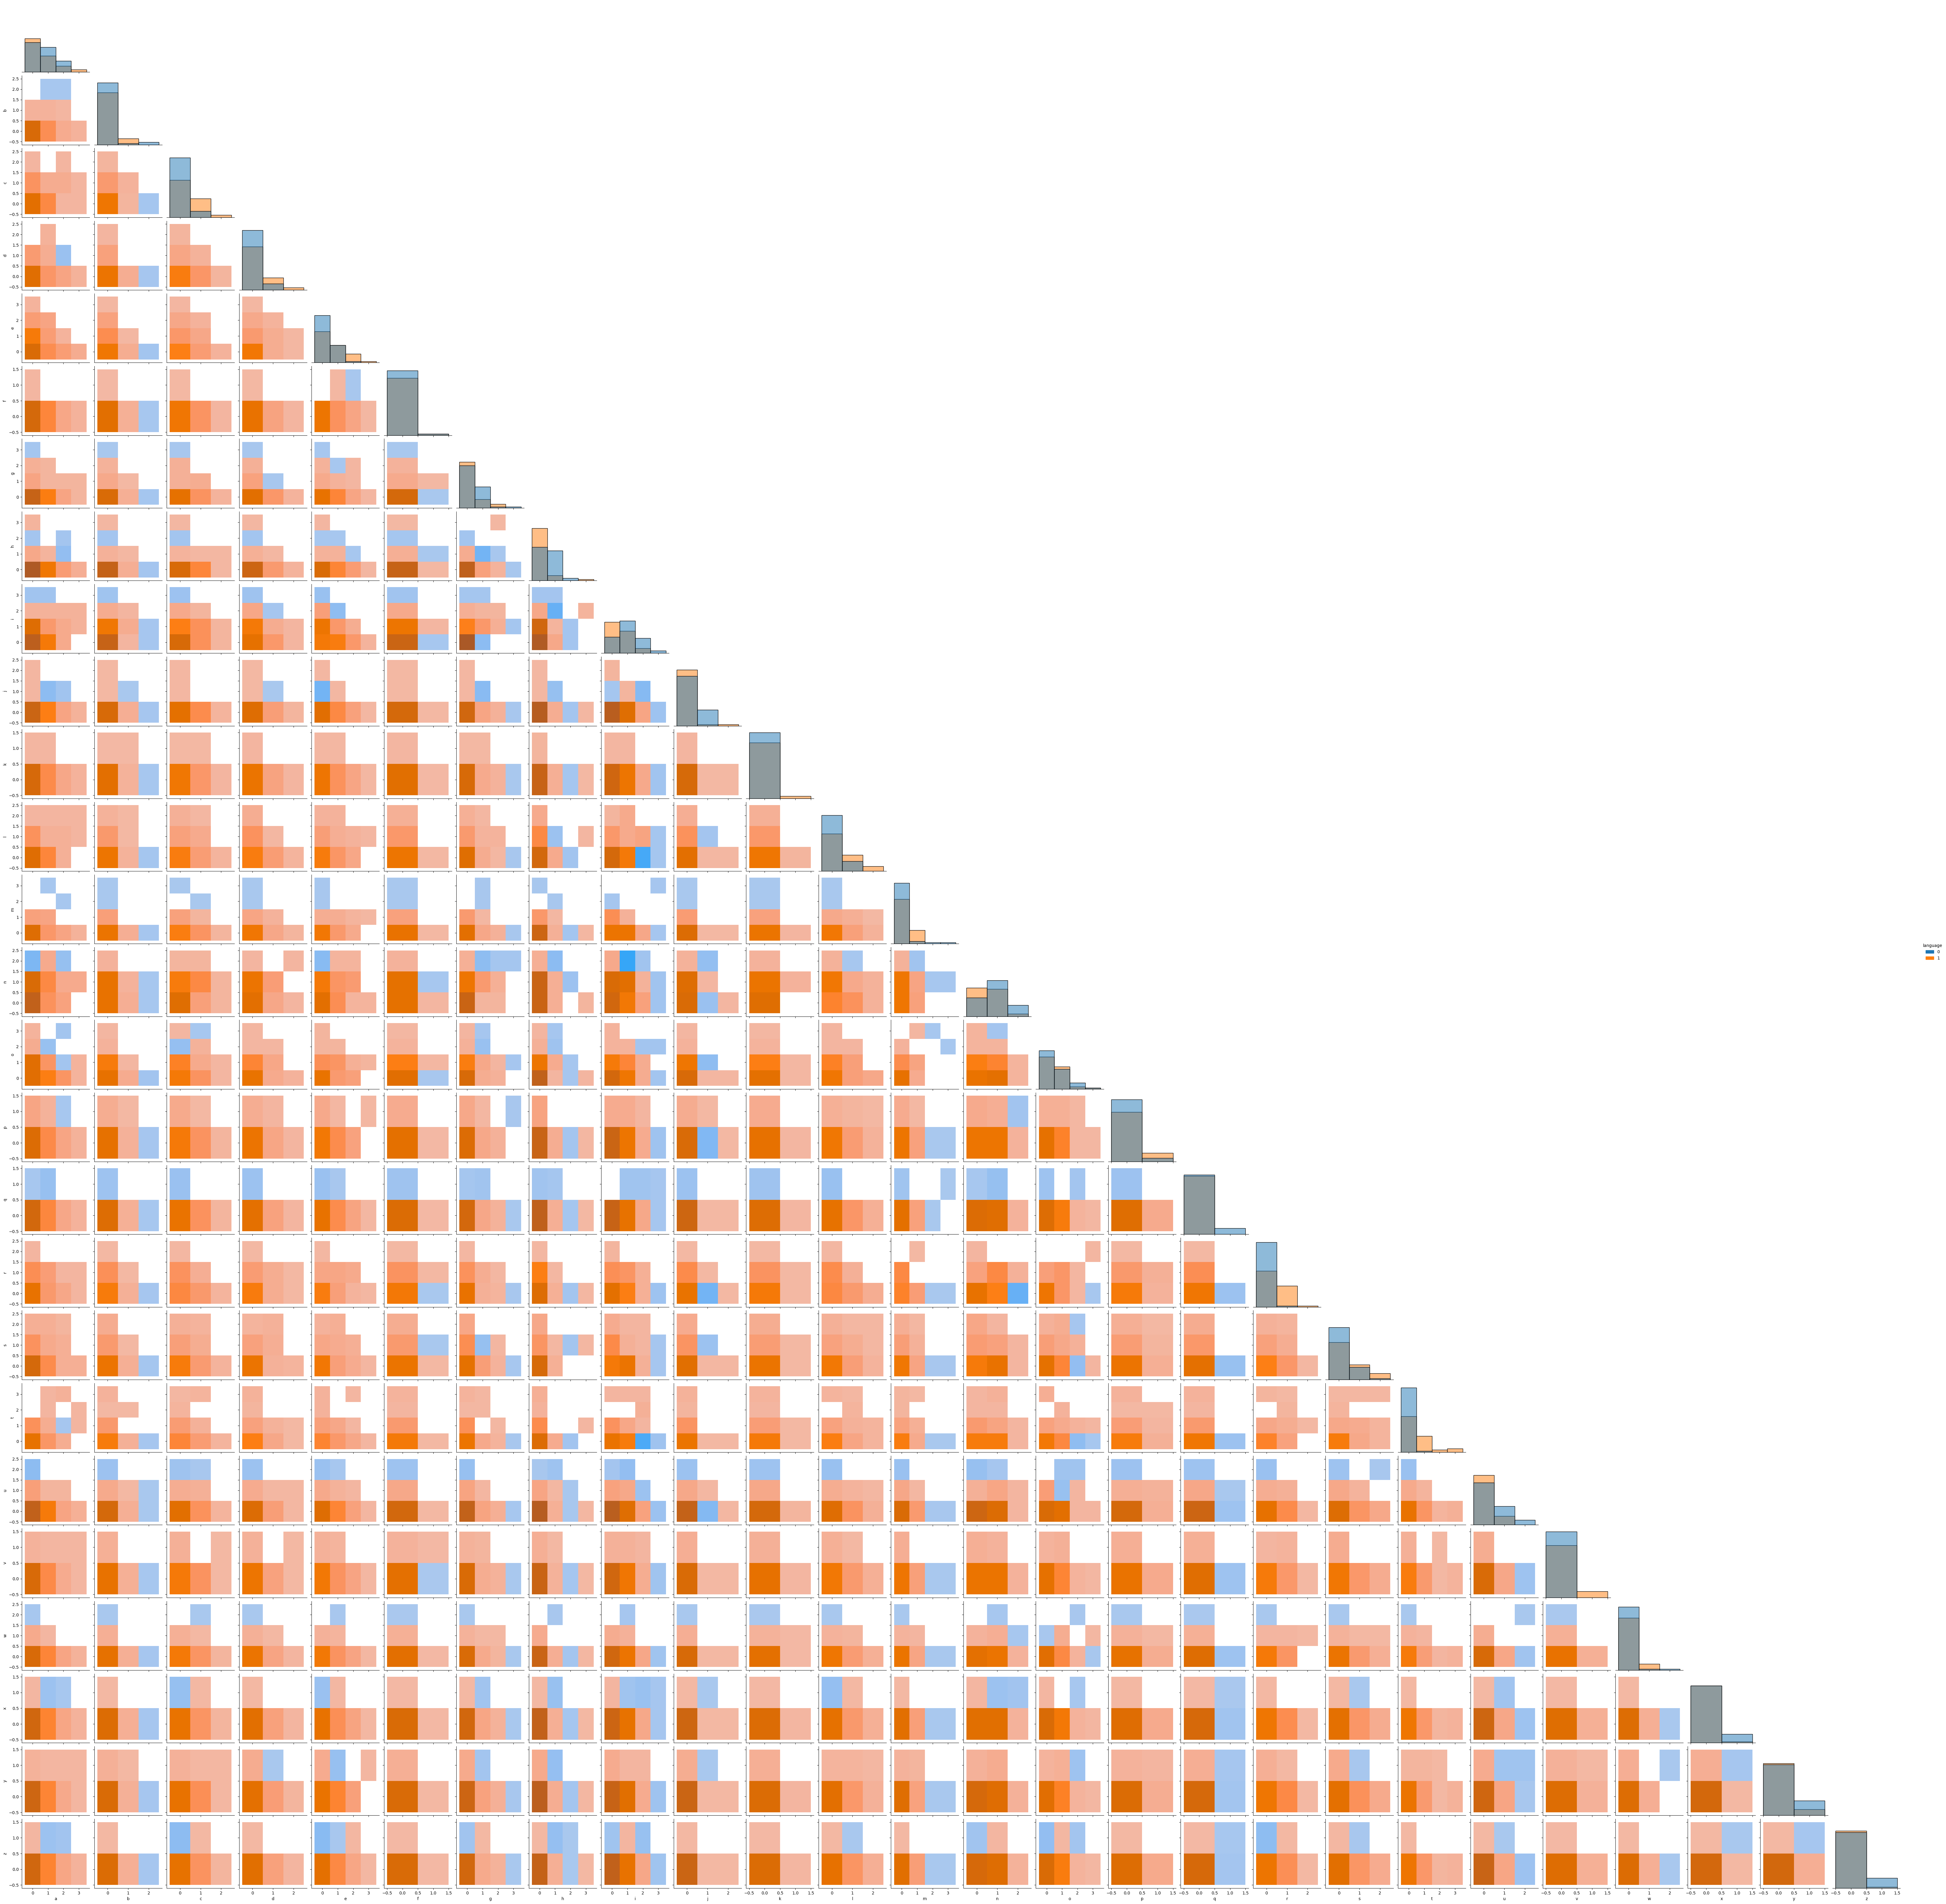

In [6]:
# connect language labels to letter frequencies
concat_df = pd.concat([freqs_df, words_df['language']], axis=1)
# plotting the entire df would be slow, so we'll only plot a sample
sample_df = concat_df.sample(n=100, random_state=42)

plt.tight_layout()

# Plot paired letter frequencies
from seaborn import pairplot
pairplot(sample_df, hue='language', kind='hist', corner=True, plot_kws={'discrete': True}, diag_kws={'discrete': True})

Here, language 0 (blue) is Mandarin, and language 1 (orange) is English. We can see some differences already: letters like "q," "y," "z," and "x" that are rare in English are more common in Mandarin, while "v" occurs in English but is completely absent in Mandarin. Certain combinations of letters as well, such as "xi" and "zh" are common in Mandarin but impossible in English, and others like "sl" and "pl" are not uncommon in English but in Mandarin they are almost entirely missing. 

## 1.4 Polynomial Features
This is to help account for relationships between letters as seen in the pairplot above. 

In [7]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
poly_freqs = freqs_arr.copy()
poly_freqs = poly.fit_transform(poly_freqs)
print(poly_freqs)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## 1.5 Preprocessing Function

### 1.5.1 Data splitting function

In [8]:
from sklearn.model_selection import train_test_split

def get_train_valid_test_data(
    X: np.ndarray, 
    y: np.ndarray, 
):
    """ Randomizes and then splits the data into train, validation, and test sets.

        Args:
            X: Data given as a 2D matrix

            y: Labels given as a vector 
    """
    assert isinstance(X, np.ndarray), f'`X` must be a NumPy array, got type {type(X)} instead.'
    assert isinstance(y, np.ndarray), f'`y` must be a NumPy array, got type {type(y)} instead.'
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size=.8, random_state=42)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, train_size=.8, random_state=42)

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

### 1.5.2 Actual preprocessing function

In [9]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_data(poly_features=False, include_bias=False) -> Tuple[np.ndarray, ...]:
    """ Gets preprocessed data for training, validation, and testing

        Args:
            poly_features: Indicates whether to return X with
            polynomial features, or just raw features. 
            
            include_bias: Indicates whether to include a 
            bias column (column of ones) in the feature data. 

        Return:
            A tuple of NumPy arrays where indices 0-1 
            contain the training data/targets, indices 2-3
            contain the validation data/targets, and 4-5
            contain the testing data/targets.
    """
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = None, None, None, None, None, None

    if poly_features:
        X = poly_freqs
    else:
        X = freqs_arr
    if include_bias:
        X = np.hstack(np.ones(X.shape[0], -1), X)
    y = words_df['language'].values
    
    # Data splitting
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_train_valid_test_data(X, y)
    
    # Standardization
    scl = StandardScaler()
    scl.fit(X_trn)
    X_trn = scl.transform(X_trn)
    X_vld = scl.transform(X_vld)
    X_tst = scl.transform(X_tst)
    
    return X_trn, y_trn.reshape(-1, 1), X_vld, y_vld.reshape(-1, 1), X_tst, y_tst.reshape(-1, 1)

## 1.6 Other Utilities

### 1.6.1 Metrics

In [10]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix
)

### 1.6.2 Confusion matrix

In [11]:
def plot_confusion_matrix(
    y: np.ndarray, 
    y_hat: np.ndarray, 
    class_names: Dict[int, str] = None
) -> pd.DataFrame:
    """ Plots a pretty and labeld version of Sklerarn's confusion matrix

        Args:
            y: Ground truth labels given as a 1D vector

            y_hat: Predicted labels given as a 1D vector

            class_names: Dictionary mapping labels to class names.

        Returns:
            A confusion matrix casted as a DataFrame
    """
    y =  y.flatten() # reshape to make 1D vector for consistency
    y_hat = y_hat.flatten() # reshape to make 1D vector for consistency
    
    cfm = confusion_matrix(y_true=y, y_pred=y_hat)    
    
    labels = np.sort(np.unique(y))
    if class_names is not None:
        classes = []
        for l in labels:
            class_name = class_names.get(l, l)
            classes.append(class_name)
        labels = classes
        
    columns, index = labels, labels
    cfm_df = pd.DataFrame(cfm, index=index, columns=columns)
    sns.heatmap(cfm_df, annot=True)
    plt.show()
    return cfm_df

# 2 Naive Bayes with Polynomial Features
## 2.1 Setup

In [12]:
# Create model
from sklearn.naive_bayes import GaussianNB
gnb_poly = GaussianNB()

# Get data
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data(poly_features=True)

# Class names
class_names = {
    0: 'Mandarin',
    1: 'English'
}

<span style="color:blue">
    
## Note: How to read confusion matricies
### Y-axis: Actual class
### X-axis: Predicted class

</span>

## 2.2 Training

Training accuracy: 0.8180484501956063


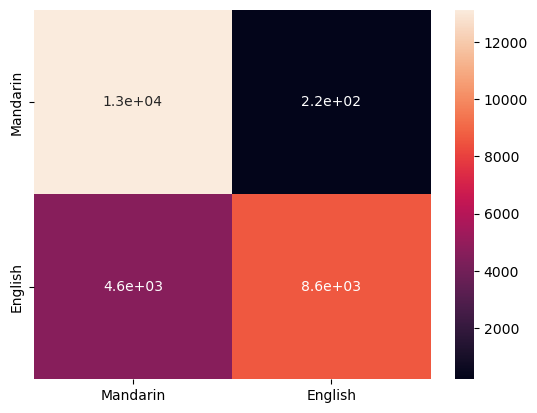

,Mandarin,English
Mandarin,13124,216
English,4621,8623


In [13]:
gnb_poly.fit(X_trn, np.ravel(y_trn))
y_hat_trn = gnb_poly.predict(X_trn)
acc_trn = accuracy_score(np.ravel(y_trn), np.ravel(y_hat_trn))
print(f"Training accuracy: {acc_trn}")
plot_confusion_matrix(y=y_trn, y_hat=y_hat_trn, class_names=class_names)

## 2.3 Validation

Validation accuracy: 0.8238037917544387


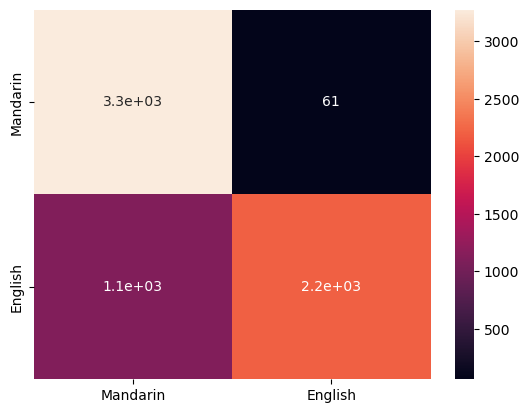

,Mandarin,English
Mandarin,3274,61
English,1110,2201


In [14]:
y_hat_vld = gnb_poly.predict(X_vld)
acc_vld = accuracy_score(np.ravel(y_vld), np.ravel(y_hat_vld))
print(f"Validation accuracy: {acc_vld}")
plot_confusion_matrix(y=y_vld, y_hat=y_hat_vld, class_names=class_names)

## 2.4 Testing

Testing accuracy: 0.8094607607125662


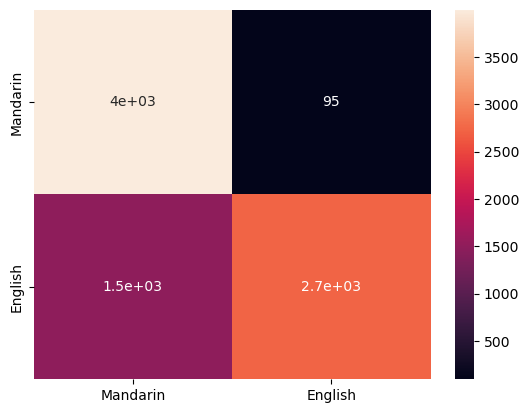

,Mandarin,English
Mandarin,3999,95
English,1488,2726


In [15]:
y_hat_tst = gnb_poly.predict(X_tst)
acc_tst = accuracy_score(np.ravel(y_tst), np.ravel(y_hat_tst))
print(f"Testing accuracy: {acc_tst}")
plot_confusion_matrix(y=y_tst, y_hat=y_hat_tst, class_names=class_names)

## 2.5 Observations

The Naive Bayes classifier gives somewhat disappointing results, scoring only around 80% accuracy on average. It seems to be very good at identifying Mandarin words correctly, but just over a third of the English words it sees are misidentified. 

Perhaps one reason the perfomance was lower than hoped was because of the use of polynomial features. I had hoped that using polynomial features would boost accuracy by helping account for relations between letters, which Naive Bayes would not normally account for. However, because Naive Bayes assumes (conditional) independence between all features, including features that are completely dependent on each other may have just confused it and made things more difficult (e.g., the frequency of a * b is directly dependent on the individual frequencies of a and b). 

Next, we will try running Naive Bayes again without polynomial features to see if performance improves. 

# 3 Naive Bayes with Plain Features
## 3.1 Setup

In [16]:
# Get data
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data()

# Create seperate model
gnb_plain = GaussianNB()

## 3.2 Training

Training accuracy: 0.8005567258501354


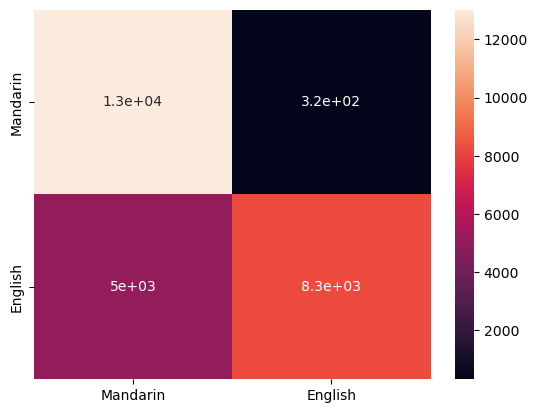

,Mandarin,English
Mandarin,13025,315
English,4987,8257


In [17]:
gnb_plain.fit(X_trn, np.ravel(y_trn))
y_hat_trn = gnb_plain.predict(X_trn)
acc_trn = accuracy_score(np.ravel(y_trn), np.ravel(y_hat_trn))
print(f"Training accuracy: {acc_trn}")
plot_confusion_matrix(y=y_trn, y_hat=y_hat_trn, class_names=class_names)

## 3.3 Validation

Validation accuracy: 0.8015347577490219


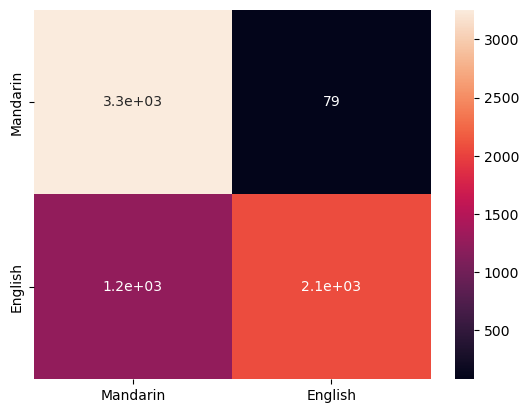

,Mandarin,English
Mandarin,3256,79
English,1240,2071


In [18]:
y_hat_vld = gnb_plain.predict(X_vld)
acc_vld = accuracy_score(np.ravel(y_vld), np.ravel(y_hat_vld))
print(f"Validation accuracy: {acc_vld}")
plot_confusion_matrix(y=y_vld, y_hat=y_hat_vld, class_names=class_names)

## 3.4 Testing

Testing accuracy: 0.7934520943668752


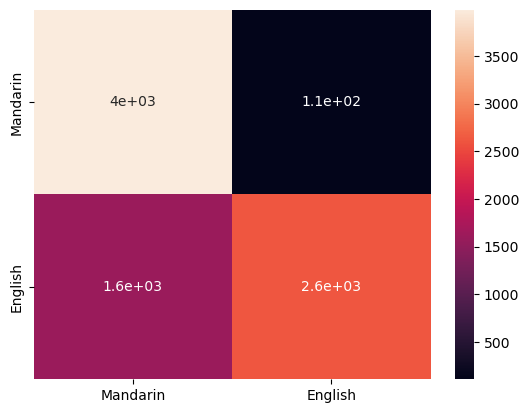

,Mandarin,English
Mandarin,3984,110
English,1606,2608


In [19]:
y_hat_tst = gnb_plain.predict(X_tst)
acc_tst = accuracy_score(np.ravel(y_tst), np.ravel(y_hat_tst))
print(f"Testing accuracy: {acc_tst}")
plot_confusion_matrix(y=y_tst, y_hat=y_hat_tst, class_names=class_names)

## 3.5 Observations

As it turns out, running Naive Bayes without polynomial features yields similar accuracy, if not slightly worse. Evidently, Naive Bayes is simply not up to this task. 

Next, we will attempt this problem using a multi-layer neural network, which will hopefully be able to understand the relationships between letters better. 

# 4 Neural Net with Plain Features

## 4.1 TensorFlow Wrapper Function

This will make TensorFlow neural networks considerably easier to set up.

In [20]:
import tensorflow as tf

def build_neural_net(
    input_shape: Tuple, 
    n_layers: int,
    n_units_per_layer: int,
    n_outputs: int,
    loss: str,
    metrics: List[str],
    optimizer: str = 'adam',
    hidden_activation: str = 'relu',
    output_activation: str = 'linear'
) -> tf.keras.Sequential:
    """ A wrapper function for TensorFlow that automatically creates a 
        neural network based on the specified parameters.

        Args:
            input_shape: a tuple signifying the shape of the input data

            n_layers: the number of hidden layers in the network
            
            n_units_per_layer: the number of neurons in each hidden layer

            n_outputs: the number of values produced by the output layer

            loss: string signifying how the model should compute loss
            
            metrics: list of strings signifying how to judge model 
                performance
            
            optimizer: string signifying the optimization algorithm to
                be used in training (defaults to 'adam')

            hidden_activation: string signifying the activation function
                to use in the hidden layers (defaults to 'relu')

            output_activation: string signifying the activation function
                to use in the output layer (defaults to 'linear')

        Return:
            A tf.keras.Sequential object containing the desired neural
                network
    """

    # Declare model and specify input shape
    out = tf.keras.Sequential([tf.keras.Input(shape=input_shape)])
    
    # Iteratively add hidden layers
    for i in range(n_layers):
        out.add(tf.keras.layers.Dense(n_units_per_layer, activation=hidden_activation))
        
    # Add the output layer
    out.add(tf.keras.layers.Dense(n_outputs, activation=output_activation))
    
    # Compile
    out.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return out

## 4.2 Setup

In [21]:
# Get data
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data()

# Initialize network
nn_plain = build_neural_net(
    input_shape=(X_trn.shape[1],),
    n_layers=4,
    n_units_per_layer=12,
    n_outputs=1,
    loss='binary_crossentropy',
    metrics=["accuracy"],
    output_activation='sigmoid'
)

## 4.3 Training

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4968 - loss: 0.6936 - val_accuracy: 0.7331 - val_loss: 0.6099
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7791 - loss: 0.5515 - val_accuracy: 0.8366 - val_loss: 0.3886
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8558 - loss: 0.3442 - val_accuracy: 0.8729 - val_loss: 0.2955
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8754 - loss: 0.2847 - val_accuracy: 0.8893 - val_loss: 0.2599
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8912 - loss: 0.2541 - val_accuracy: 0.8974 - val_loss: 0.2409
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8981 - loss: 0.2352 - val_accuracy: 0.8984 - val_loss: 0.2301
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9019 - loss: 0.2263 - val_accuracy: 0.9040 - val_loss: 0.2199
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9054 - loss: 0.2216 - val_accuracy: 0.9

<Axes: >

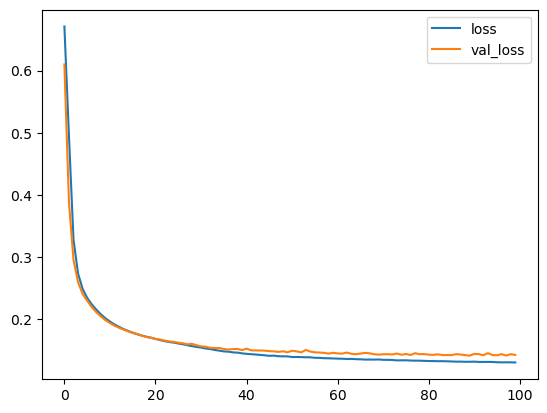

In [22]:
# Train
losses = nn_plain.fit(X_trn, y_trn, validation_data=(X_vld, y_vld), batch_size=512, epochs=100)

# Plot learning curve
loss_df = pd.DataFrame(losses.history)
loss_df.loc[:,['loss','val_loss']].plot()

831/831 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Training accuracy: 0.9477881432440566


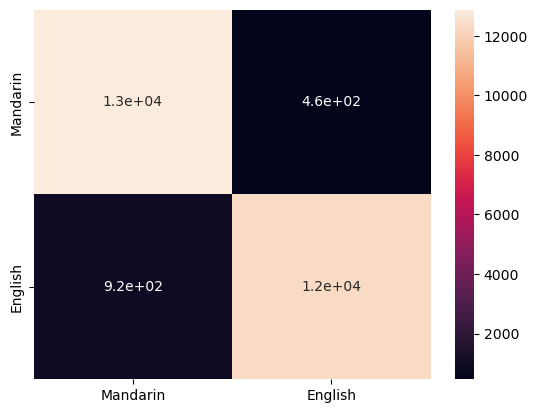

,Mandarin,English
Mandarin,12875,465
English,923,12321


In [23]:
# Display accuracy
y_hat_trn = nn_plain.predict(X_trn)
# Convert probabilities to binary predictions
y_hat_trn = np.array([1 if x >= 0.5 else 0 for x in y_hat_trn])
acc_trn = accuracy_score(np.ravel(y_trn), np.ravel(y_hat_trn))
print(f"Training accuracy: {acc_trn}")
plot_confusion_matrix(y=y_trn, y_hat=y_hat_trn, class_names=class_names)

## 4.4 Validation

208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training accuracy: 0.945681613000301


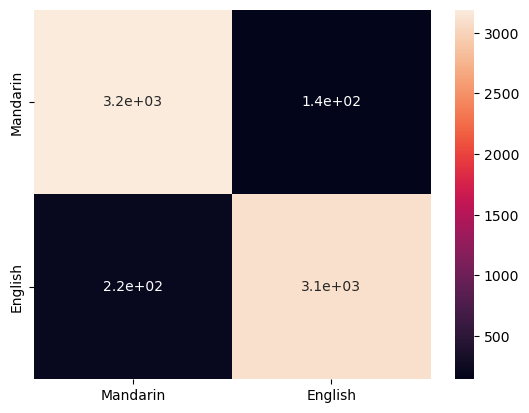

,Mandarin,English
Mandarin,3190,145
English,216,3095


In [24]:
y_hat_vld = nn_plain.predict(X_vld)
# Convert probabilities to binary predictions
y_hat_vld = np.array([1 if x >= 0.5 else 0 for x in y_hat_vld])
acc_vld = accuracy_score(np.ravel(y_vld), np.ravel(y_hat_vld))
print(f"Training accuracy: {acc_vld}")
plot_confusion_matrix(y=y_vld, y_hat=y_hat_vld, class_names=class_names)

## 4.5 Testing

260/260 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Training accuracy: 0.9348820414058738


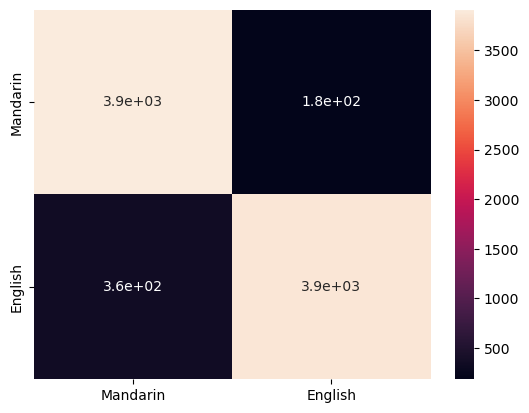

,Mandarin,English
Mandarin,3910,184
English,357,3857


In [25]:
y_hat_tst = nn_plain.predict(X_tst)
# Convert probabilities to binary predictions
y_hat_tst = np.array([1 if x >= 0.5 else 0 for x in y_hat_tst])
acc_tst = accuracy_score(np.ravel(y_tst), np.ravel(y_hat_tst))
print(f"Training accuracy: {acc_tst}")
plot_confusion_matrix(y=y_tst, y_hat=y_hat_tst, class_names=class_names)

## 4.6 Observations

As I hoped, the neural network achieves much higher accuracy than the Naive Bayes. Interestingly, the network seems to work better when it is wide and shallow than when it is thin and deep. It also still has more trouble correctly identifying English words than Chinese words, but not nearly as much. 

Just to cover all our bases, we will finish by training another neural network using polynomial features. 

# 5 Neural Net with Polynomial Features